This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

### Setup

In [131]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [132]:
tf.__version__

'2.10.1'

In [3]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\danie\appdata\local\temp\pip-req-build-f27jjk75
  Resolved https://github.com/tensorflow/docs to commit bbc0b9c70fc0bd4411793d1b0bcc56ef1dbc2405
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\danie\AppData\Local\Temp\pip-req-build-f27jjk75'


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [5]:
batch_size = 8

In [6]:

def parse_image_set(original_img_path):
    # Nombre base de la imagen
    original_img_path = original_img_path.numpy().decode('utf-8')

    filename = os.path.splitext(os.path.basename(original_img_path))[0]

    target_size = (128, 128)
    
    # Cargar imagen original (RGB)
    original_img = tf.io.read_file(original_img_path)
    original_img = tf.image.decode_jpeg(original_img, channels=3)
    original_img = tf.image.resize(original_img, (128, 128))
    original_img = (original_img / 255) -1.
    
    # Cargar imagen f1 (grayscale)
    f1_path = os.path.join(feature_img_dir, f'{filename}_landmarks.jpg')
    f1_img = tf.io.read_file(f1_path)
    f1_img = tf.image.decode_jpeg(f1_img, channels=1)
    f1_img = tf.image.resize(f1_img, target_size)
    f1_img = (f1_img / 255) -1.

    
    # Cargar imagen f2 (grayscale)
    f2_path = os.path.join(feature_img_dir, f'{filename}_mask.jpg')
    f2_img = tf.io.read_file(f2_path)
    f2_img = tf.image.decode_jpeg(f2_img, channels=1)
    f2_img = tf.image.resize(f2_img, target_size)
    f2_img = (f2_img / 255) -1.

    
    # Cargar imagen f3 (RGB)
    f3_path = os.path.join(feature_img_dir, f'{filename}_face_part.jpg')
    f3_img = tf.io.read_file(f3_path)
    f3_img = tf.image.decode_jpeg(f3_img, channels=3)
    f3_img = tf.image.resize(f3_img, target_size)
    f3_img = (f3_img / 255) -1.

    
    # Concatenar las imágenes
    combined_img = tf.concat([
        original_img,     # RGB
        f1_img,           # Grayscale
        f2_img,           # Grayscale
        f3_img            # RGB
    ], axis=-1)
    
    return combined_img

def create_image_dataset(original_img_dir, feature_img_dir, batch_size=32, target_size=(128, 128)):
    # Obtener lista de rutas de imágenes originales
    original_img_paths = [
        os.path.join(original_img_dir, f) 
        for f in os.listdir(original_img_dir) 
        if f.endswith('.jpg')
    ]
    list_ds = tf.data.Dataset.list_files(str(original_img_dir+'/*'), shuffle=False)
    list_ds = list_ds.shuffle(100, reshuffle_each_iteration=False)

    AUTOTUNE = tf.data.AUTOTUNE

    list_ds = list_ds.map(
        lambda x: tf.py_function(
            func=parse_image_set, 
            inp=[x], 
            Tout=tf.float32
        ), 
        num_parallel_calls=AUTOTUNE
    )
    def xd(x):
        return x.shape[0] != batch_size
    
    list_ds = list_ds.batch(batch_size)
    list_ds = list_ds.filter(lambda x: tf.shape(x)[0] == batch_size)

    return list_ds

original_img_dir = 'D:/My Files/UNSA/PFCIII/prepro/test/original'
feature_img_dir = 'D:/My Files/UNSA/PFCIII/prepro/test/processed'

# Crear dataset
dataset = create_image_dataset(original_img_dir, feature_img_dir, batch_size=batch_size)

print(dataset)


<FilterDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)>


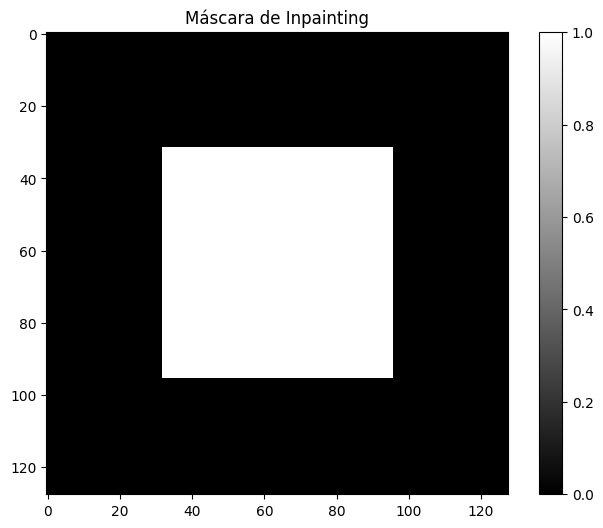

In [95]:
import tensorflow as tf
import matplotlib.pyplot as plt

def create_inpainting_mask(image_size=(128, 128)):
    # Crear tensor de la mitad del tamaño
    mask_center = tf.ones((image_size[0]//2, image_size[1]//2), dtype=tf.float32)
    
    # Aplicar padding para llevarlo al tamaño original
    paddings = tf.constant([
        [image_size[0]//4, image_size[0]//4],  # Padding vertical
        [image_size[1]//4, image_size[1]//4]   # Padding horizontal
    ])
    
    # Aplicar padding
    out = tf.pad(mask_center, paddings, mode='CONSTANT', constant_values=0)
    
    return out


# Visualizar
plt.figure(figsize=(8,6))
plt.imshow(create_inpainting_mask(), cmap='gray')
plt.title('Máscara de Inpainting')
plt.colorbar()
plt.show()

In [8]:
# normalization_layer = tf.keras.layers.Rescaling(1./255, offset=-1)
# train_dataset = train_images.map(lambda x: normalization_layer(x))

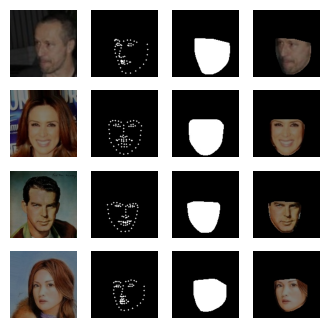

In [9]:
# Batch and shuffle the data
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = dataset

def show_images(train_dataset):
  fig = plt.figure(figsize=(4, 4))
  for x, i in  enumerate(train_dataset.take(4)):
      plt.subplot(4, 4, x * 4+ 1)
      plt.imshow((i[0,:,:,0:3] +1.) /2.)
      plt.axis('off')
      plt.subplot(4, 4, x * 4 + 2)
      plt.imshow((i[0,:,:,3] +1.) /2., cmap='gray')
      plt.axis('off')
      plt.subplot(4, 4, x * 4 + 3)
      plt.imshow((i[0,:,:,4] +1.) /2., cmap='gray')
      plt.axis('off')
      plt.subplot(4, 4, x * 4 + 4)
      plt.imshow((i[0,:,:,5:8] +1.) /2.)
      plt.axis('off')
  plt.show()

show_images(dataset)


## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

In [10]:
def make_extractor_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 8]))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())

    z_mean = layers.Dense(128, name="z_mean")(model.output)
    z_log_var = layers.Dense(128, name="z_log_var")(model.output)
    
    # Model outputs
    return tf.keras.Model(inputs=model.input, outputs=[z_mean, z_log_var], name="encoder")

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [11]:
def make_generator_model():
    l_dim = 128
    input_latent = layers.Input(shape=(l_dim,))
    input_image = layers.Input(shape=(128, 128, 3))
    mask = layers.Input(shape=(128, 128, 1))

    
    # Procesar el vector latente
    y = layers.Dense(8*8*512)(input_latent)
    y = layers.Reshape((8, 8, 512))(y)
    # Concatenar la imagen de entrada si es necesario    
    ones_x = tf.ones_like(input_image)[:, :, :, 0:1]
    print("mask", tf.shape(mask), tf.shape(ones_x))
    x = layers.Concatenate(axis=-1, name="concat_mask")([input_image, ones_x *mask ])
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')( x)    
    x = c1 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)    
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = c2 = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same' , activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = c3 = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = c4 = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)



    x = layers.Concatenate(axis=-1)([x,y])
    x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Concatenate(axis=-1)([x,c4])
    x = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Concatenate(axis=-1)([x,c3])
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Concatenate(axis=-1)([x,c2])
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Concatenate(axis=-1)([x,c1])
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    output = layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh')(x)
    # Crear modelo con dos inputs
    model = tf.keras.Model(inputs=[input_latent, input_image, mask], outputs=output)
    
    return model

In [97]:
def create_batch_mask(size):
    new_mask = create_inpainting_mask()
    batch_mask = tf.expand_dims(new_mask, -1)
    batch_mask =  tf.expand_dims(batch_mask, 0)
    batch_mask = tf.tile(batch_mask, [size, 1, 1, 1])
    return batch_mask
print(tf.shape(create_batch_mask(8))[0])

tf.Tensor(8, shape=(), dtype=int32)


Use the (as yet untrained) generator to create an image.

In [129]:
def mask_rgb():
    gray_mask = create_inpainting_mask()
    tf.print("Mask values:", tf.shape(gray_mask))
    rgb_mask = tf.expand_dims(gray_mask, -1)
    rgb_mask = tf.tile(rgb_mask, [1, 1, 3])
    tf.print("Mask values:", tf.shape(rgb_mask))
    return tf.identity(rgb_mask)

mask KerasTensor(type_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None), inferred_value=[None, 128, 128, 1], name='tf.compat.v1.shape_10/Shape:0', description="created by layer 'tf.compat.v1.shape_10'") KerasTensor(type_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None), inferred_value=[None, 128, 128, 1], name='tf.compat.v1.shape_11/Shape:0', description="created by layer 'tf.compat.v1.shape_11'")
Mask values: [128 128]


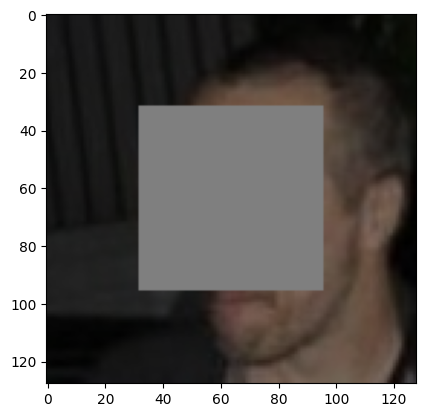

In [114]:
generator = make_generator_model()

noise = tf.random.normal([batch_size, 128])
for item in train_dataset.take(1):
    rgb_mask = mask_rgb()
    imcomplete = item[:,:,:,0:3] * (1. - rgb_mask)
    generated_image = generator([noise,imcomplete , create_batch_mask(batch_size)], training=False)

    plt.imshow((generated_image[0] + 1.) / 2.)
    plt.imshow((imcomplete[0] + 1.) / 2.)
    # plt.imshow(((generated_image[0] * (1. - rgb_mask)) + 1.) / 2.)

### The Discriminator

The discriminator is a CNN-based image classifier.

In [115]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [116]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor(
[[0.00828048]
 [0.01151247]
 [0.00188505]
 [0.00112623]
 [0.01078689]
 [0.00859113]
 [0.00136427]
 [0.00093179]], shape=(8, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [117]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [118]:
extractor = make_extractor_model()

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [119]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [120]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [121]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def mse_loss(y_true, y_pred):
  r_loss = tf.reduce_mean(tf.square(y_true - y_pred), axis = [1,2,3])
  return 1000 * tf.reduce_mean(r_loss)


def sampling(z_mean, z_log_sigma):
  eps = tf.random.normal(shape = tf.shape(input=z_mean))
  std = z_mean + tf.exp(z_log_sigma / 2) * eps

  z = tf.add(z_mean, tf.multiply(std, eps))
  return z

def kl_loss(mean, log_var):
  kl_loss =  -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis = 1)
  return tf.reduce_mean(kl_loss)

def extractor_loss(y_true, y_pred, mean, log_var):
  mse = mse_loss(y_true, y_pred)
  kl = kl_loss(mean, log_var)
  return mse + kl

The discriminator and the generator optimizers are different since you will train two networks separately.

In [122]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
extractor_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [123]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 extractor_optimizer=extractor_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 extractor=extractor)

## Define the training loop


In [124]:
EPOCHS = 50
noise_dim = 128
num_examples_to_generate = 8

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
print(tf.shape(seed))

tf.Tensor([  8 128], shape=(2,), dtype=int32)


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [125]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
def train_step(images):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape,\
      tf.GradientTape() as extra_tape:

      mean, log_var = extractor(images, training=True)

      mit = mask_rgb()

      sample = sampling(mean, log_var)
      images = images[:,:,:,0:3]
      tf.print("shapes info", tf.shape(images), tf.shape(mit))
      incomplete_images = images * (1. - rgb_mask)

      generated_images = generator([sample, incomplete_images,create_batch_mask(tf.shape(images)[0])], training=True)
       
      generated_images = images * (1. - mit) + (generated_images * mit)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      disc_loss = discriminator_loss(real_output, fake_output)
      ext_loss = extractor_loss(images, generated_images, mean, log_var)
      gen_loss = generator_loss(fake_output) + ext_loss

    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_extra = extra_tape.gradient(ext_loss, extractor.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    extractor_optimizer.apply_gradients(zip(gradients_of_extra, extractor.trainable_variables))

    return gen_loss, disc_loss, ext_loss

In [126]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    gen_loss = disc_loss = ext_loss = 0

    for step, image_batch in enumerate(dataset):
      gen_loss, disc_loss, ext_loss = train_step(image_batch)

    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    tf.rint("gen", gen_loss)
    tf.print("dis", disc_loss)
    tf.print("ext", ext_loss)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [133]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  seed = tf.random.normal([batch_size, noise_dim])
  rgb_mask = mask_rgb()
  for i in train_dataset.take(1):
      sample = i[:,:,:,0:3] * (1. - rgb_mask)
      m2 = create_batch_mask(tf.shape(sample)[0])
      predictions = model([test_input, sample, m2], training=False)

  fig = plt.figure(figsize=(4, 4))


  for i in range(tf.shape(predictions)[0]):
      mix = sample[i] * (1. - rgb_mask) + (predictions[i] * rgb_mask)
      plt.subplot(4, 4, i+1)
      plt.imshow((mix +1.) /2.)
      plt.axis('off')

  plt.savefig('res/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes

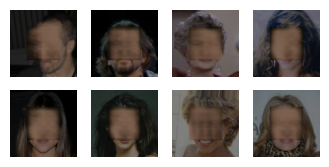

gen tf.Tensor(5.369371, shape=(), dtype=float32)
dis tf.Tensor(1.3305771, shape=(), dtype=float32)
ext tf.Tensor(4.425817, shape=(), dtype=float32)
Time for epoch 1 is 8.37880253791809 sec
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [

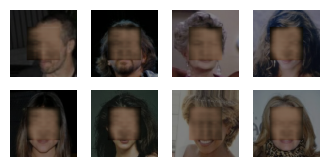

gen tf.Tensor(5.052099, shape=(), dtype=float32)
dis tf.Tensor(1.2946336, shape=(), dtype=float32)
ext tf.Tensor(4.040138, shape=(), dtype=float32)
Time for epoch 2 is 7.846919298171997 sec
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: 

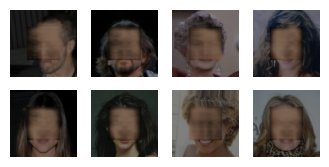

gen tf.Tensor(5.1040344, shape=(), dtype=float32)
dis tf.Tensor(1.2340863, shape=(), dtype=float32)
ext tf.Tensor(4.2113085, shape=(), dtype=float32)
Time for epoch 3 is 7.994088888168335 sec
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values

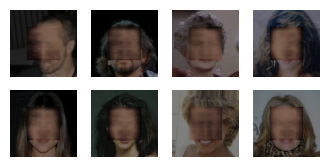

gen tf.Tensor(5.069882, shape=(), dtype=float32)
dis tf.Tensor(1.2496645, shape=(), dtype=float32)
ext tf.Tensor(4.2561274, shape=(), dtype=float32)
Time for epoch 4 is 8.256113767623901 sec
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values:

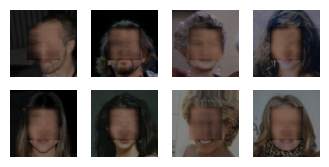

gen tf.Tensor(5.157406, shape=(), dtype=float32)
dis tf.Tensor(1.2092271, shape=(), dtype=float32)
ext tf.Tensor(4.17125, shape=(), dtype=float32)
Time for epoch 5 is 7.880026340484619 sec
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [

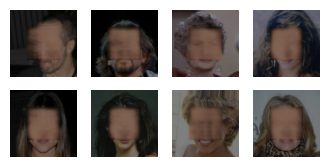

gen tf.Tensor(6.6159267, shape=(), dtype=float32)
dis tf.Tensor(1.1611401, shape=(), dtype=float32)
ext tf.Tensor(5.6075864, shape=(), dtype=float32)
Time for epoch 6 is 7.884944200515747 sec
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values

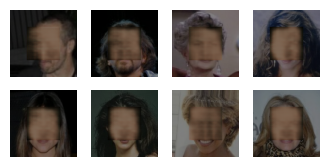

gen tf.Tensor(4.777977, shape=(), dtype=float32)
dis tf.Tensor(1.2820834, shape=(), dtype=float32)
ext tf.Tensor(3.754848, shape=(), dtype=float32)
Time for epoch 7 is 7.8225367069244385 sec
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values:

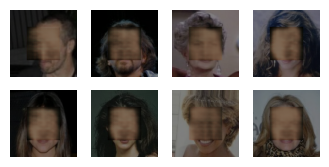

gen tf.Tensor(4.852565, shape=(), dtype=float32)
dis tf.Tensor(1.2041918, shape=(), dtype=float32)
ext tf.Tensor(3.930154, shape=(), dtype=float32)
Time for epoch 8 is 7.878232002258301 sec
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: 

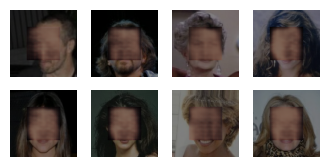

gen tf.Tensor(4.5550795, shape=(), dtype=float32)
dis tf.Tensor(1.1999453, shape=(), dtype=float32)
ext tf.Tensor(3.615165, shape=(), dtype=float32)
Time for epoch 9 is 7.894014835357666 sec
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [128 128 3]
shapes info [8 128 128 3] [128 128 3]
Mask values: [128 128]
Mask values: [1 128 384]
shapes info [8 128 128 3] [1 128 384]


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:Mul]

In [134]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [54]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('res/image_at_epoch_{:04d}.png'.format(EPOCHS))

In [ ]:
display_image(15)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/res/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
